# Controls Preprocessing

Script follows the preprocessing workflow provided by the scBestPractices online textbook for processing of scRNAseq datasets for downstream analysis.

Adapted for use on the Controls (adrenal gland) dataset prior to dataset integration.

### Packages

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import pathlib
import glob
import os
import seaborn as sns
from rds2py import as_summarized_experiment, read_rds
from matplotlib import pyplot as plt
from scipy.stats import median_abs_deviation

In [4]:
sc.settings.verbosity = 2             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.6 anndata==0.10.3 umap==0.5.4 numpy==1.23.4 scipy==1.12.0 pandas==1.5.3 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.10.8 pynndescent==0.5.11


## Load raw data

In [6]:
# Setting file paths
jansky = '/project/data/gew123/Raw_h5ad/Controls_final/Ctrl_Jansky_raw.h5ad'
kildesiute = '/project/data/gew123/Raw_h5ad/Controls_final/Ctrl_Kildesiute_raw.h5ad'
kameneva = '/project/data/gew123/Raw_h5ad/Controls_final/Ctrl_Kameneva_raw.h5ad'

jansky_processed = '/project/data/gew123/Processed_h5ad/Jansky_CTRL_processed.h5ad'
kildesiute_processed = '/project/data/gew123/Processed_h5ad/Kildesiute_CTRL_processed.h5ad'
kameneva_processed = '/project/data/gew123/Processed_h5ad/Kameneva_CTRL_processed.h5ad'

figures = '/project/data/gew123/Processed_h5ad/Figures'

### Jansky Control

In [109]:
# Read in data
adata = sc.read_h5ad(jansky)

In [42]:
# Check
adata

AnnData object with n_obs × n_vars = 100337 × 28422
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'timepoint2', 'celltype', 'ID'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'

#### Quality Control & Filtering Cells

normalizing counts per cell
    finished (0:00:03)


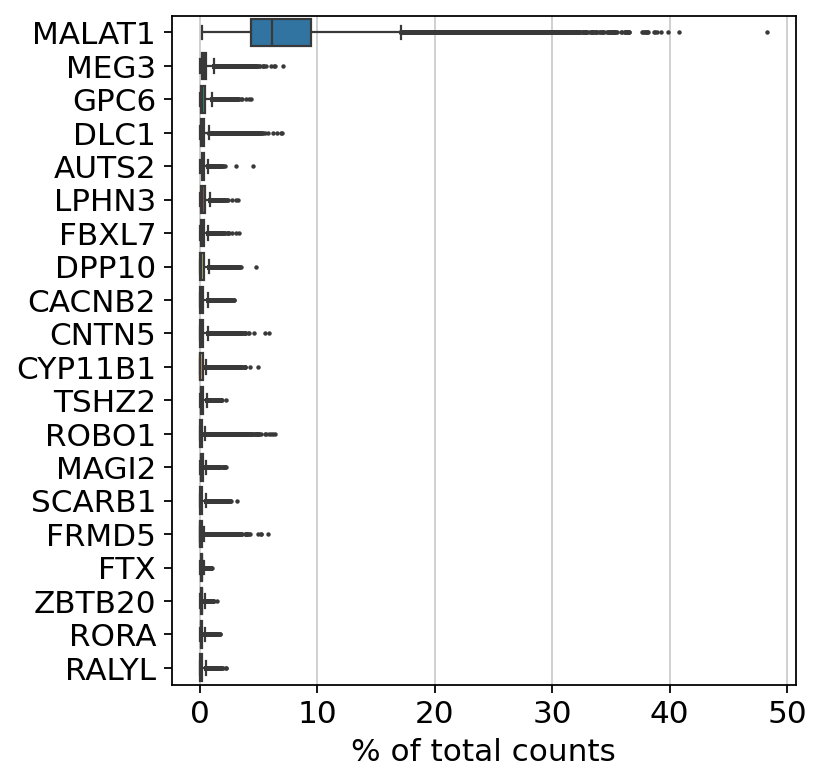

In [19]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [20]:
# Subset mitochondrial genes 
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# Ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# Hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [21]:
# Filter out by mt, ribo, & hb genes
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)

# Check
adata

AnnData object with n_obs × n_vars = 100337 × 28422
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'timepoint2', 'celltype', 'ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

/project/soft/linux64/anaconda/Anaconda3-2023.09-0-Linux-x86_64/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


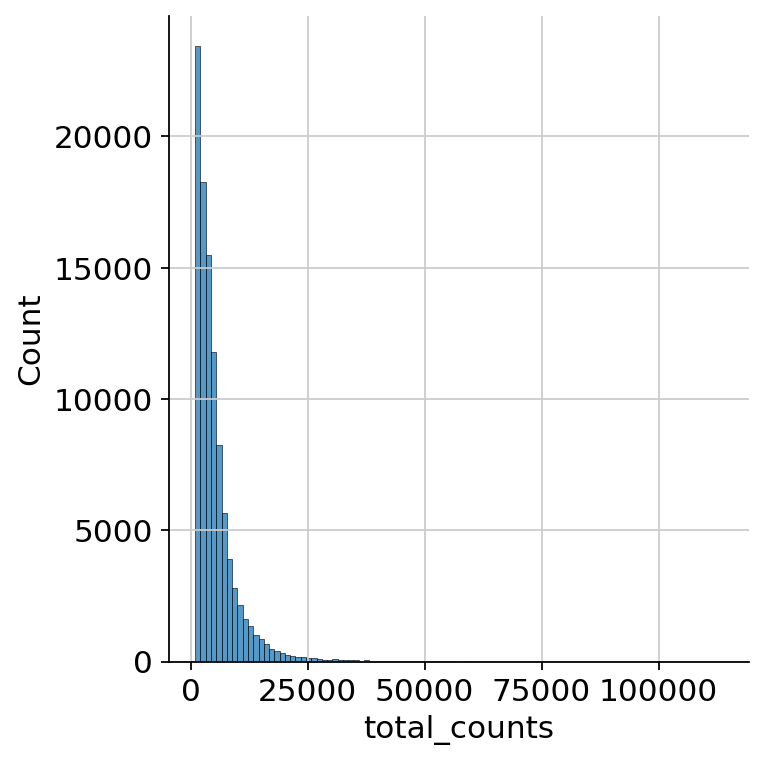

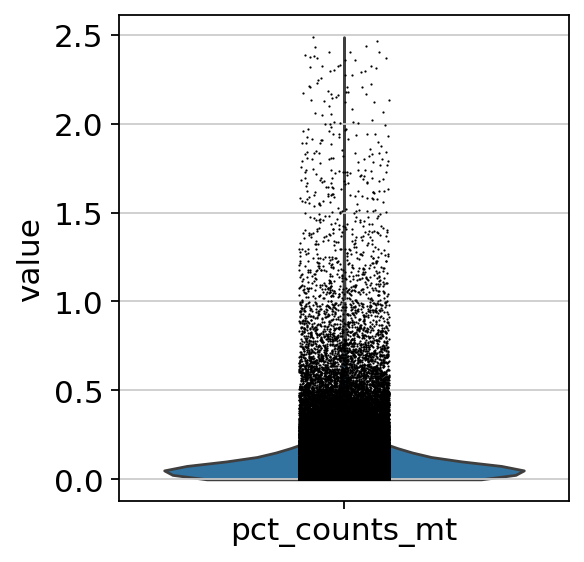

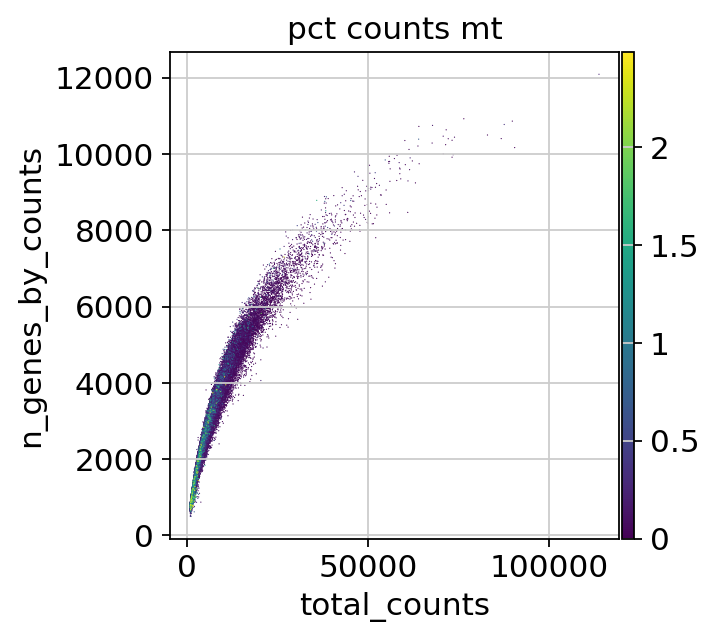

In [23]:
# Plot 3 QC covariates respectively
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", save="_jansky_MT_count.png")

In [15]:
## Automated (performed better than manual):
# Define function to take in filtering metric
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier


# Apply to QC covariates each with a threshold of 5 MADs ### why 5??????? check
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
print("Low quality cells:")
print(adata.obs.outlier.value_counts(), '\n')

# Filter out cells with MT count greater than 8%
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)

print("Cells with high mitochondrial gene expression:")
print(adata.obs.mt_outlier.value_counts())

Low quality cells:
False    99022
True      1315
Name: outlier, dtype: int64 

Cells with high mitochondrial gene expression:
False    86415
True     13922
Name: mt_outlier, dtype: int64


In [16]:
# Automated (cont.):
# Filter cells based on low quality / high mit count

print('Filtering cells...\n')
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Filtering cells...

Total number of cells: 100337
Number of cells after filtering of low quality cells: 85205


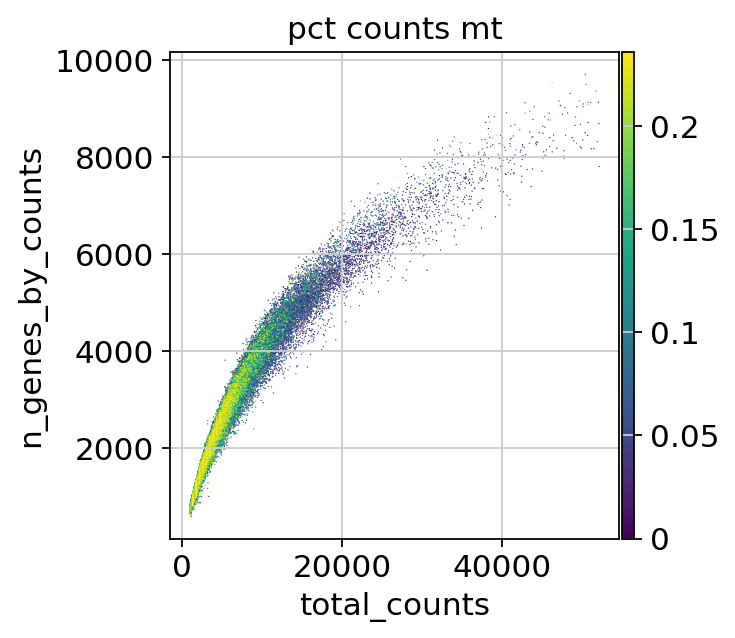

In [17]:
# Plot to confirm sufficient filtering threshold was applied
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", save="_jansky_MT_count.png")

In [13]:
# Also filter out cells with less than 200 genes and genes expressed in less than 3 cells
sc.pp.filter_cells(adata, min_genes=200)
# sc.pp.filter_genes(adata, min_cells=3)

In [18]:
adata

AnnData object with n_obs × n_vars = 48237 × 26344
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'seurat_clusters', 'anno_new', 'CNV', 'celltype', 'patientID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

### Normalization

In [34]:
# Get scaled counts
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)

# Perform transformation
adata.layers["log1p"] = sc.pp.log1p(scales_counts["X"], copy=True)

normalizing counts per cell
    finished (0:00:03)


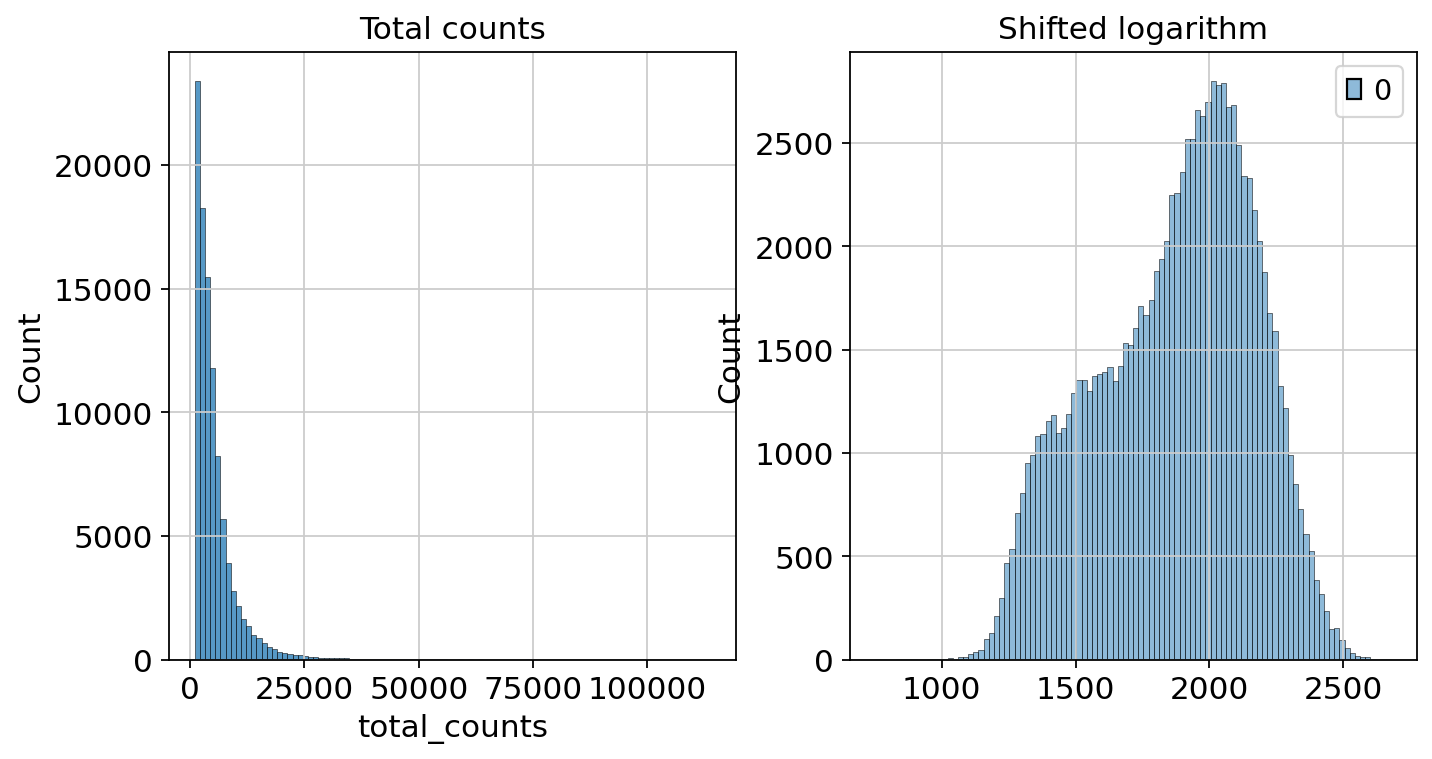

<Figure size 320x320 with 0 Axes>

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot before normalisation
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
plt.savefig(f'{figures}/Jansky_CTRL_raw.png', bbox_inches='tight')

# Plot after normalisation
p2 = sns.histplot(adata.layers["log1p"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()
plt.savefig(f'{figures}/Jansky_CTRL_log.png', bbox_inches='tight')

In [39]:
# Save processed file after normalization
adata.write(jansky_processed)

In [ ]:
processed

In [40]:
# Run this after saving normalized data just to get count
sc.pp.filter_genes(adata, min_cells=3)

filtered out 322 genes that are detected in less than 3 cells


In [23]:
adata

AnnData object with n_obs × n_vars = 48237 × 25700
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'seurat_clusters', 'anno_new', 'CNV', 'celltype', 'patientID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    layers: 'log1p'

### Kildesiute Control

In [61]:
# Read in data
adata = sc.read_h5ad(kildesiute)

In [64]:
adata

AnnData object with n_obs × n_vars = 57972 × 33694
    obs: 'GestationalAge', 'SampleName', 'Annotation', 'nCount_RNA', 'nFeature_RNA', 'mtGenes', 'hspGenes', 'riboGenes'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap'

In [63]:
# Check
adata.obs

,GestationalAge,SampleName,Annotation,nCount_RNA,nFeature_RNA,mtGenes,hspGenes,riboGenes
index,,,,,,,,
babyAdrenal1_AAACCTGAGAATTGTG,w8,w8,Cortex,9274.718256,2617,0.153302,0.011036,0.221010
babyAdrenal1_AAACCTGAGCGATGAC,w8,w8,Mesenchyme,4621.511225,1801,0.039960,0.014135,0.279912
babyAdrenal1_AAACCTGAGCTTCGCG,w8,w8,Cortex,10279.489787,2984,0.097298,0.023925,0.268133
babyAdrenal1_AAACCTGAGGCACATG,w8,w8,Cortex,12099.983510,3218,0.087512,0.014115,0.226316
babyAdrenal1_AAACCTGAGGCGCTCT,w8,w8,Cortex,3811.952597,1549,0.000641,0.016383,0.245097
...,...,...,...,...,...,...,...,...
5698STDY7839917_TTTGTCATCCAGTAGT,w11,w11,Cortex,21364.533076,4712,0.167259,0.021405,0.176720
5698STDY7839917_TTTGTCATCGACCAGC,w11,w11,Sympathoblastic,2066.896650,1404,0.065147,0.012963,0.084298
5698STDY7839917_TTTGTCATCGAGAGCA,w11,w11,Endothelium,10601.142843,3343,0.051403,0.025406,0.196625


#### Quality Control & Filtering Cells

normalizing counts per cell
    finished (0:00:02)


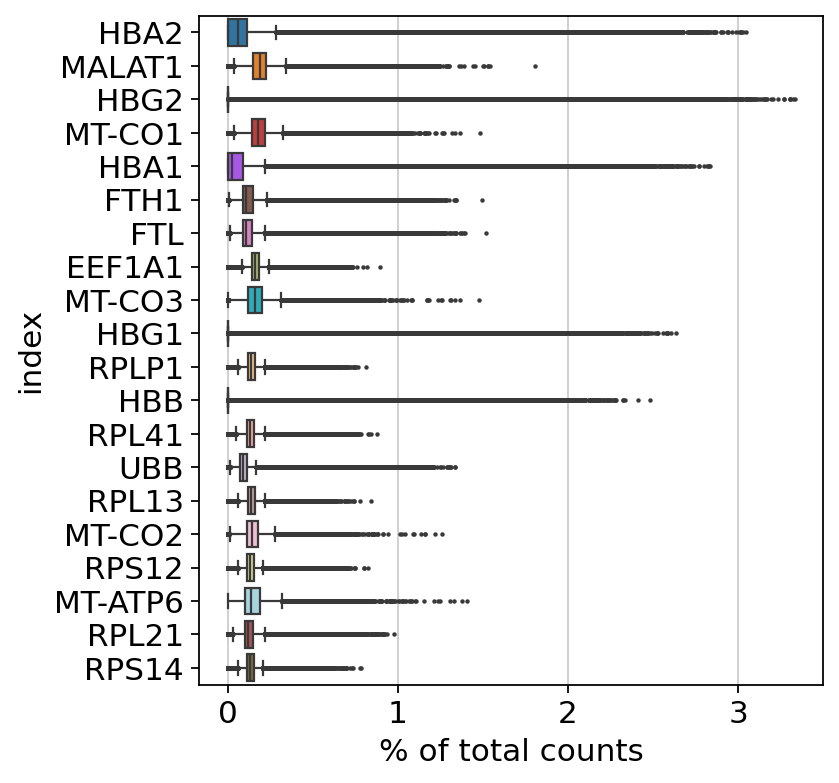

In [65]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [47]:
# Subset mitochondrial genes 
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# Ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# Hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [48]:
# Filter out by mt, ribo, & hb genes
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)

# Check
adata

AnnData object with n_obs × n_vars = 57972 × 33694
    obs: 'GestationalAge', 'SampleName', 'Annotation', 'nCount_RNA', 'nFeature_RNA', 'mtGenes', 'hspGenes', 'riboGenes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_pca', 'X_umap'

/project/soft/linux64/anaconda/Anaconda3-2023.09-0-Linux-x86_64/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


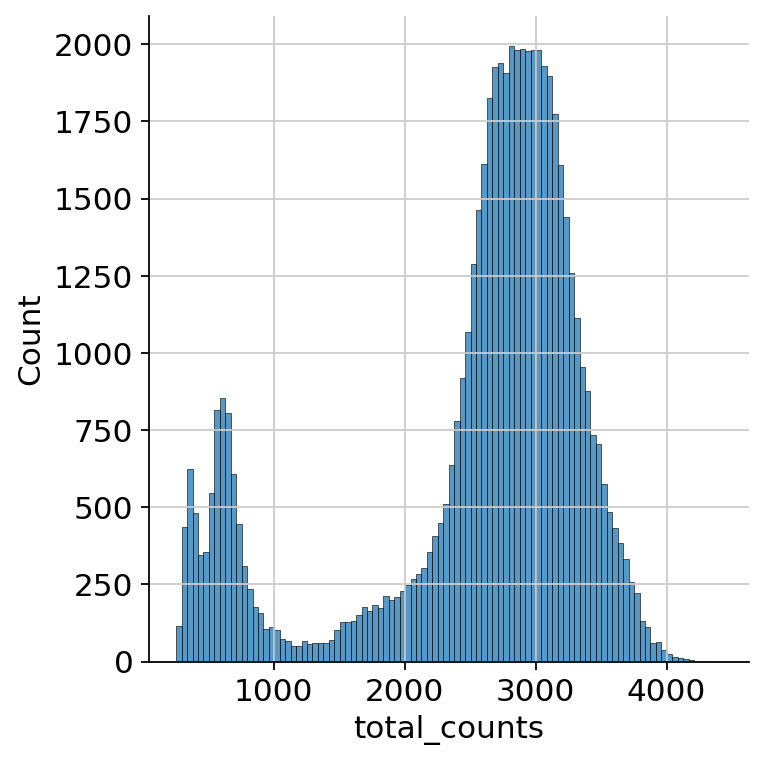

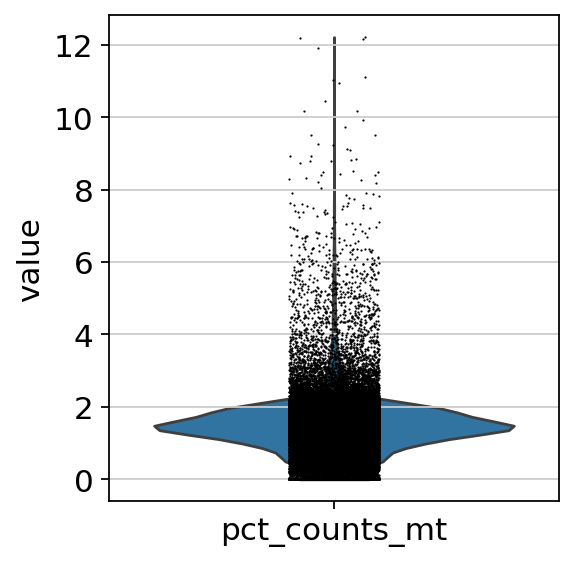

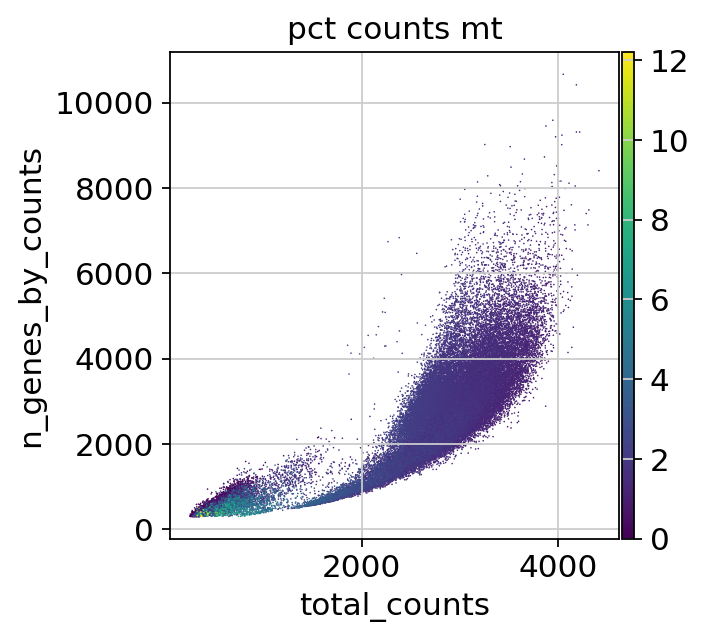

In [49]:
# Plot 3 QC covariates respectively
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [52]:
## Automated (performed better than manual):
# Define function to take in filtering metric
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier


# Apply to QC covariates each with a threshold of 5 MADs ### why 5??????? check
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
print("Low quality cells:")
print(adata.obs.outlier.value_counts(), '\n')

# Filter out cells with MT count greater than 8%
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)

print("Cells with high mitochondrial gene expression:")
print(adata.obs.mt_outlier.value_counts())

Low quality cells:
False    48932
True      9040
Name: outlier, dtype: int64 

Cells with high mitochondrial gene expression:
False    52279
True      5693
Name: mt_outlier, dtype: int64


In [53]:
# Automated (cont.):
# Filter cells based on low quality / high mit count

print('Filtering cells...\n')
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Filtering cells...

Total number of cells: 57972
Number of cells after filtering of low quality cells: 47317


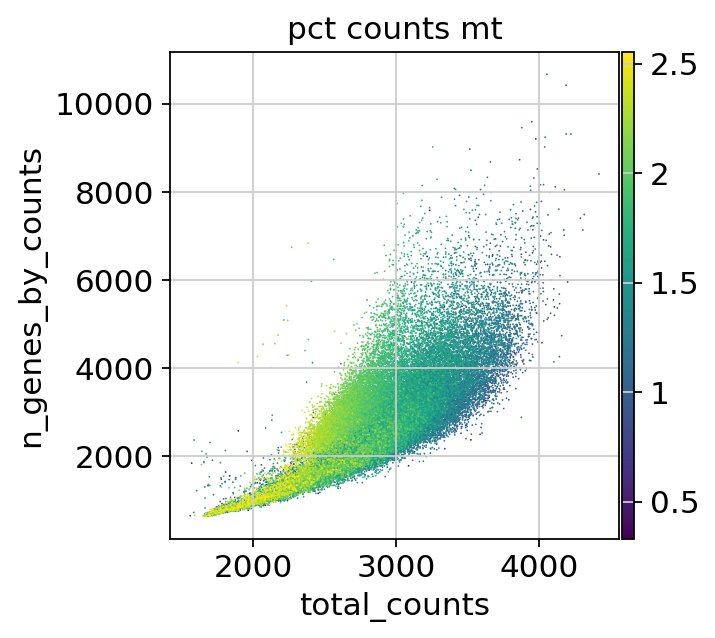

In [54]:
# Plot to confirm sufficient filtering threshold was applied
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", save="_kildesiute_CTRL_MT_count.png")

In [13]:
# Also filter out cells with less than 200 genes and genes expressed in less than 3 cells
sc.pp.filter_cells(adata, min_genes=200)
# sc.pp.filter_genes(adata, min_cells=3)

In [55]:
adata

AnnData object with n_obs × n_vars = 47317 × 33694
    obs: 'GestationalAge', 'SampleName', 'Annotation', 'nCount_RNA', 'nFeature_RNA', 'mtGenes', 'hspGenes', 'riboGenes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_pca', 'X_umap'

### Normalization

In [57]:
# Get scaled counts
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)

# Perform transformation
adata.layers["log1p"] = sc.pp.log1p(scales_counts["X"], copy=True)

normalizing counts per cell
    finished (0:00:01)


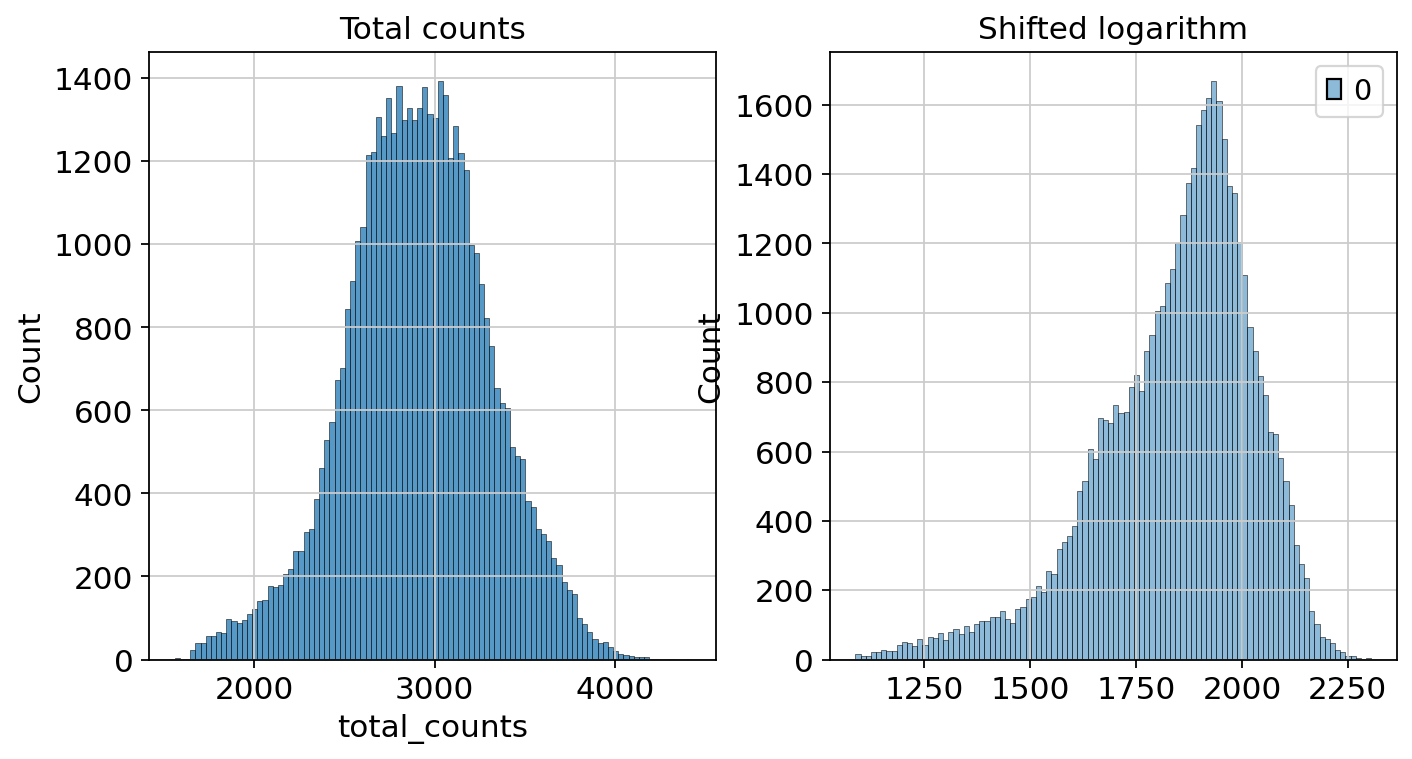

<Figure size 320x320 with 0 Axes>

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot before normalisation
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
plt.savefig(f'{figures}/Kildesiute_CTRL_raw.png', bbox_inches='tight')

# Plot after normalisation
p2 = sns.histplot(adata.layers["log1p"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()
plt.savefig(f'{figures}/Kildesiute_CTRL_log.png', bbox_inches='tight')

In [59]:
# Save processed file after normalization
adata.write(kildesiute_processed)

In [60]:
# Run this after saving normalized data just to get count
sc.pp.filter_genes(adata, min_cells=3)

filtered out 7712 genes that are detected in less than 3 cells


In [23]:
adata

AnnData object with n_obs × n_vars = 48237 × 25700
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'seurat_clusters', 'anno_new', 'CNV', 'celltype', 'patientID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    layers: 'log1p'

### Kameneva Control

In [95]:
# Read in data
adata = sc.read_h5ad(kameneva)

In [96]:
adata

AnnData object with n_obs × n_vars = 74743680 × 33538
    obs: 'Ctrl_Kameneva'

In [68]:
# Check
adata.obs

,Ctrl_Kameneva
AAACCCAAGAAACACT-1,0
AAACCCAAGAAACCAT-1,0
AAACCCAAGAAACCCA-1,0
AAACCCAAGAAACCCG-1,0
AAACCCAAGAAACCTG-1,0
...,...
TTTGTTGTCTTTGCTA-1-10,10
TTTGTTGTCTTTGCTG-1-10,10
TTTGTTGTCTTTGGAG-1-10,10
TTTGTTGTCTTTGGCT-1-10,10


In [97]:
# Immediately filter out cells with < 200 gene counts
sc.pp.filter_cells(adata, min_genes=200)

filtered out 74603138 cells that have less than 200 genes expressed


In [98]:
adata

AnnData object with n_obs × n_vars = 140542 × 33538
    obs: 'Ctrl_Kameneva', 'n_genes'

#### Quality Control & Filtering Cells

normalizing counts per cell
    finished (0:00:02)


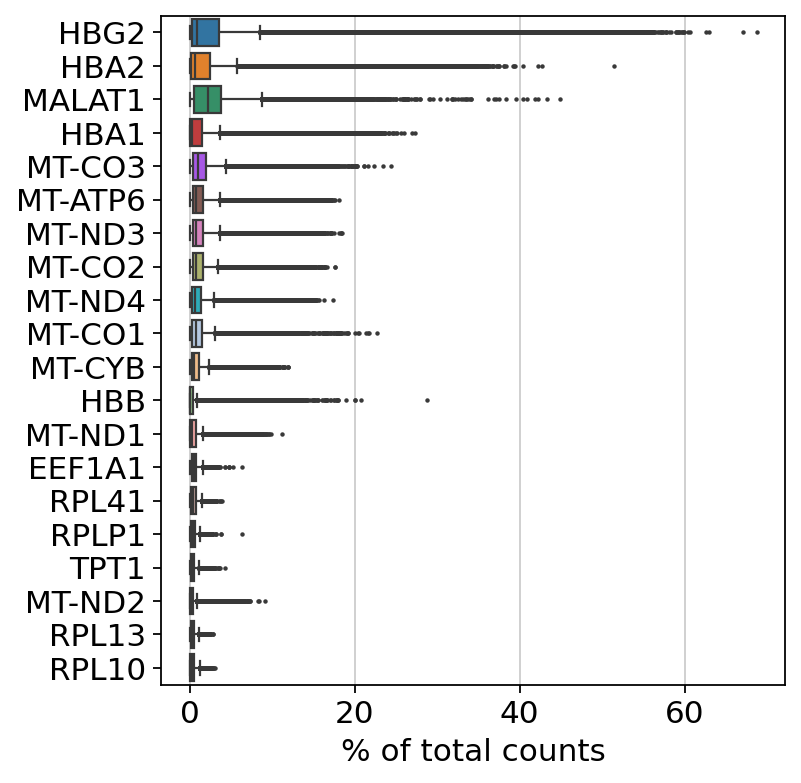

In [75]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [99]:
# Subset mitochondrial genes 
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# Ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# Hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [100]:
# Filter out by mt, ribo, & hb genes
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)

# Check
adata

AnnData object with n_obs × n_vars = 140542 × 33538
    obs: 'Ctrl_Kameneva', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

/project/soft/linux64/anaconda/Anaconda3-2023.09-0-Linux-x86_64/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


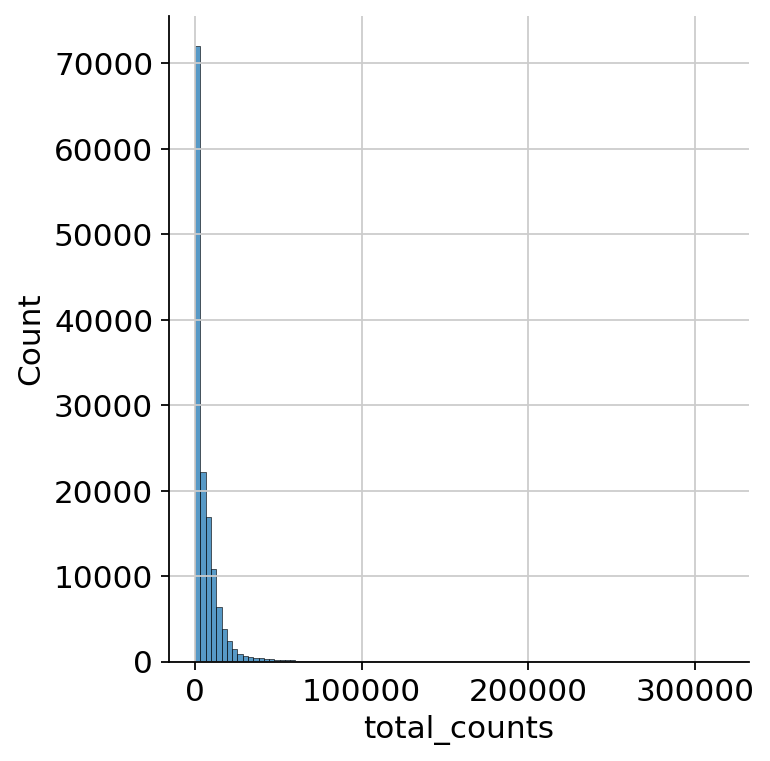

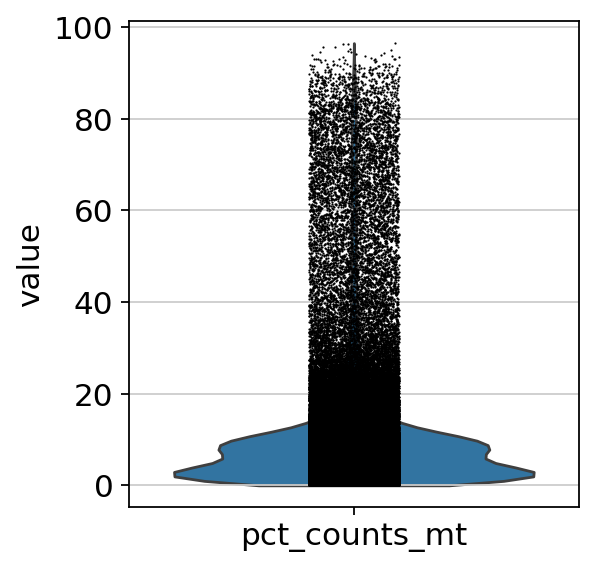

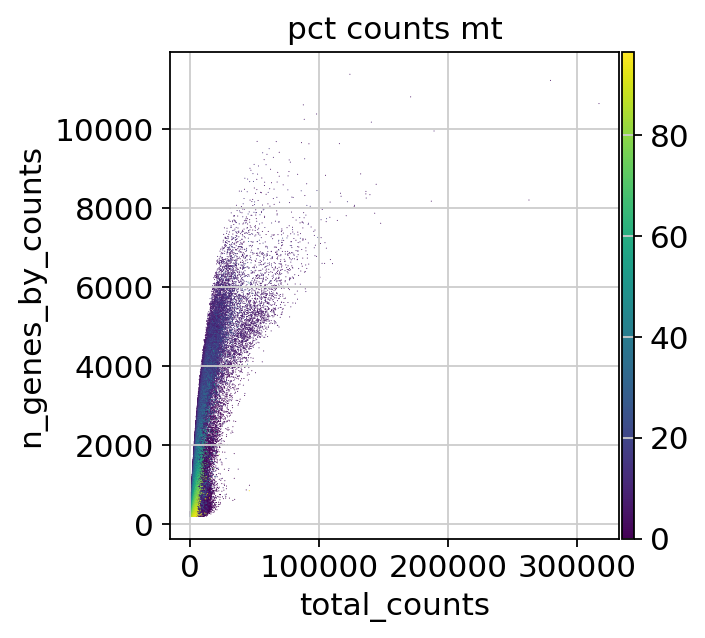

In [78]:
# Plot 3 QC covariates respectively
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [101]:
## Automated (performed better than manual):
# Define function to take in filtering metric
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier


# Apply to QC covariates each with a threshold of 5 MADs ### why 5??????? check
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
print("Low quality cells:")
print(adata.obs.outlier.value_counts(), '\n')

# Filter out cells with MT count greater than 8%
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)

print("Cells with high mitochondrial gene expression:")
print(adata.obs.mt_outlier.value_counts())

Low quality cells:
False    119579
True      20963
Name: outlier, dtype: int64 

Cells with high mitochondrial gene expression:
False    79510
True     61032
Name: mt_outlier, dtype: int64


In [102]:
# Automated (cont.):
# Filter cells based on low quality / high mit count

print('Filtering cells...\n')
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Filtering cells...

Total number of cells: 140542
Number of cells after filtering of low quality cells: 64520


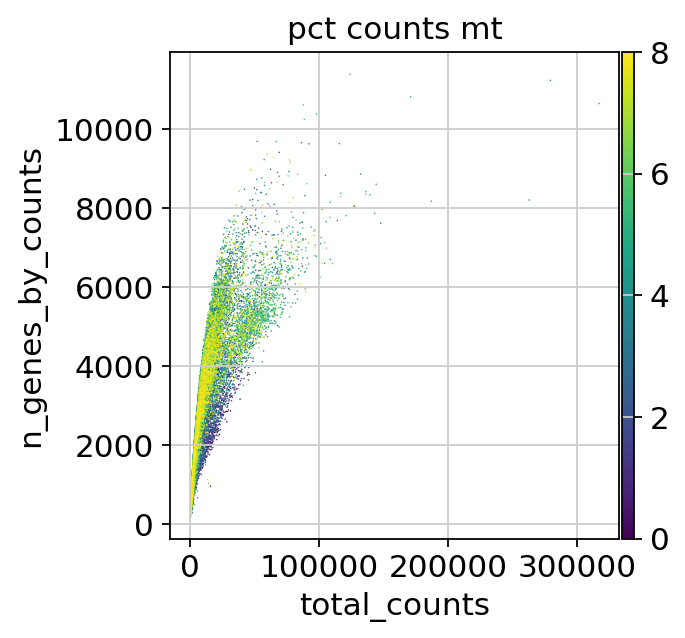

In [81]:
# Plot to confirm sufficient filtering threshold was applied
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", save="_kameneva_CTRL_MT_count.png")

In [103]:
# Also filter out cells with less than 200 genes and genes expressed in less than 3 cells
sc.pp.filter_cells(adata, min_genes=200)
# sc.pp.filter_genes(adata, min_cells=3)

In [104]:
adata

AnnData object with n_obs × n_vars = 64520 × 33538
    obs: 'Ctrl_Kameneva', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

### Normalization

In [105]:
# Get scaled counts
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)

# Perform transformation
adata.layers["log1p"] = sc.pp.log1p(scales_counts["X"], copy=True)

normalizing counts per cell
    finished (0:00:00)


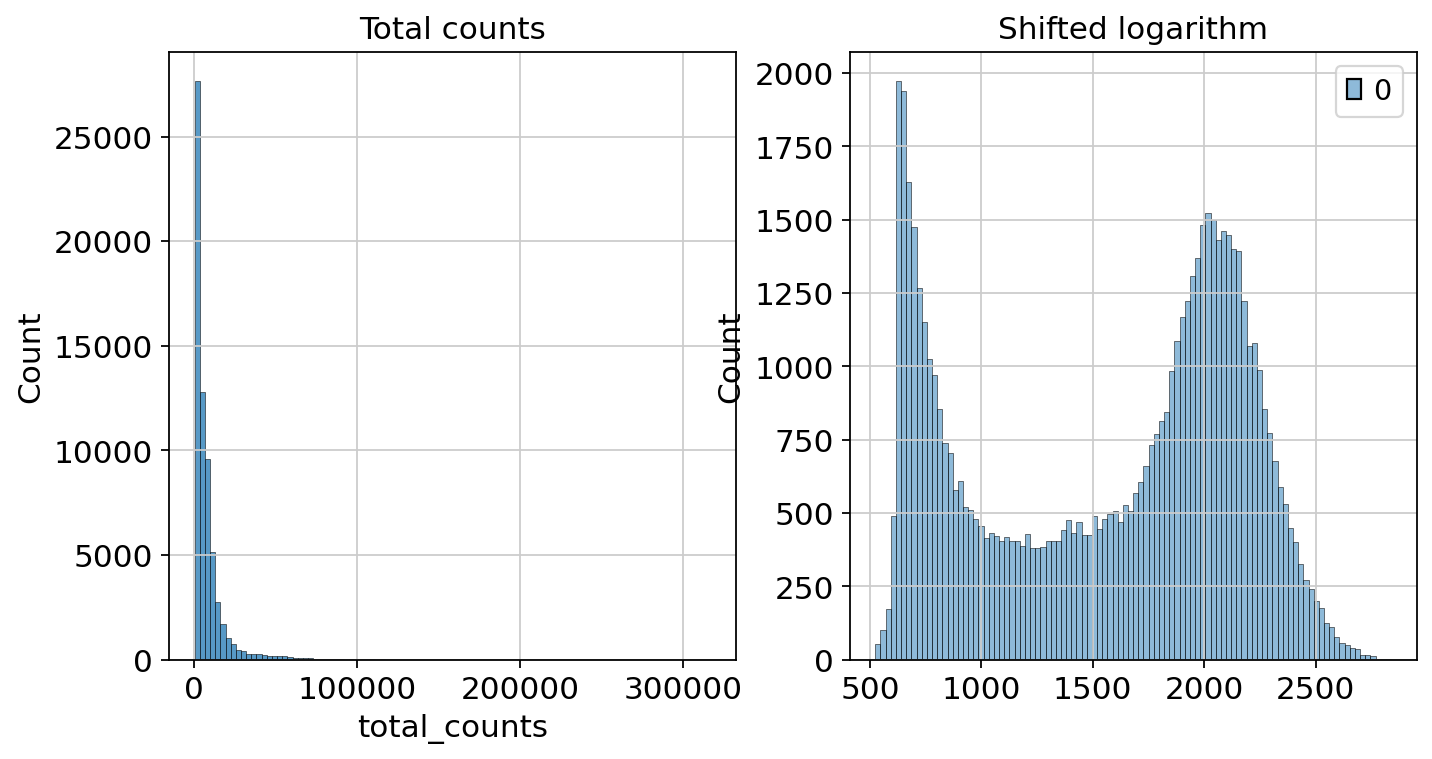

In [106]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot before normalisation
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
#plt.savefig(f'{figures}/Kameneva_CTRL_raw.png', bbox_inches='tight')

# Plot after normalisation
p2 = sns.histplot(adata.layers["log1p"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()
#plt.savefig(f'{figures}/Kameneva_CTRL_log.png', bbox_inches='tight')

In [107]:
# Save processed file after normalization
adata.write(kameneva_processed)

In [108]:
# Run this after saving normalized data just to get count
sc.pp.filter_genes(adata, min_cells=3)

filtered out 6614 genes that are detected in less than 3 cells


In [90]:
adata

AnnData object with n_obs × n_vars = 64520 × 26924
    obs: 'Ctrl_Kameneva', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    layers: 'log1p'